In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/")

from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct, plotting, umi_deduplicate


import glob
from tqdm import tqdm  # progress bar

How many colonies (unique AD-AD_BC-RPTR_BC combos) are in the Gcn4 UMI experiment?

How many reads did we get for each of the timepoint/replicates?

Max says that the 180 and 240 timepoints are undersequenced - are all the other timepoints good? (what is the acceptable #reads for each timepoint?)
this is all mostly for the RPTR reads, but it would be helpful to know the average reads needed for an AD timepoint/replicate also

In [3]:
# Path to your DuckDB database
db_path = "/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/duckdb/GCN4_final.db"

# Connect to the database
con = duckdb.connect(database=db_path)  # read_only=True if you don't want to modify

In [7]:
# Get all tables (as list of tuples)
tables = con.execute("SHOW TABLES").fetchall()

# Flatten to get table names as strings
tables = [t[0] for t in tables]  # t[0] is the table name

# Keep only tables starting with your prefix
trebl_exp_tables = [t for t in tables if t.startswith('trebl_experiment_yeast_pool_C_umi') and 'initial' in t and 'grouped' not in t and "UMI" not in t]
for table in trebl_exp_tables:
    print(table)

trebl_experiment_yeast_pool_C_umi_AD_1_0_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_1_10_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_1_15_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_1_180_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_1_240_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_1_30_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_1_5_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_2_0_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_2_10_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_2_15_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_2_180_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_2_240_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_2_30_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_2_5_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_3_0_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_3_10_AD_AD_BC_initial
trebl_experiment_yeast_pool_C_umi_AD_3_15_AD_AD_BC_initia

# How many reads did we get for each of the timepoint/replicates?

In [102]:
# Dictionary to store row counts
row_counts = {}

# Loop through tables and get row counts
for table in tqdm(trebl_exp_tables):
    try:
        count = con.execute(f"SELECT COUNT(*) FROM {table}").fetchone()[0]
        row_counts[table] = count
    except Exception as e:
        row_counts[table] = f"Error: {e}"

reads_per_sample = pd.DataFrame({'id' : row_counts.keys(), 'reads' : row_counts.values()})
reads_per_sample["sample"] = reads_per_sample["id"].str.split("umi_").str[1].str.split("_").str[:3].str.join("_")
reads_per_sample["time"] = reads_per_sample["sample"].str.split("_").str[2].astype(int)
reads_per_sample["rep"] = reads_per_sample["sample"].str.split("_").str[1].astype(int)
reads_per_sample["seq"] = reads_per_sample["sample"].str.split("_").str[0]
reads_per_sample = reads_per_sample.drop(columns = ["sample"])
reads_per_sample = reads_per_sample[reads_per_sample["reads"] > 100]
reads_per_sample

100%|██████████| 42/42 [00:00<00:00, 2267.05it/s]


,id,reads,time,rep,seq
0,trebl_experiment_yeast_pool_C_umi_AD_1_0_AD_AD...,120435636,0,1,AD
1,trebl_experiment_yeast_pool_C_umi_AD_1_10_AD_A...,133267703,10,1,AD
2,trebl_experiment_yeast_pool_C_umi_AD_1_15_AD_A...,118861797,15,1,AD
3,trebl_experiment_yeast_pool_C_umi_AD_1_180_AD_...,129094391,180,1,AD
4,trebl_experiment_yeast_pool_C_umi_AD_1_240_AD_...,136157333,240,1,AD
5,trebl_experiment_yeast_pool_C_umi_AD_1_30_AD_A...,138974129,30,1,AD
6,trebl_experiment_yeast_pool_C_umi_AD_1_5_AD_AD...,134125332,5,1,AD
7,trebl_experiment_yeast_pool_C_umi_AD_2_0_AD_AD...,151089408,0,2,AD
8,trebl_experiment_yeast_pool_C_umi_AD_2_10_AD_A...,132878970,10,2,AD
9,trebl_experiment_yeast_pool_C_umi_AD_2_15_AD_A...,142432974,15,2,AD


In [106]:
table_names_pivot = pd.pivot(columns = "seq", index= ["time", "rep"], values = 'id', data = reads_per_sample)
table_names_pivot = table_names_pivot.reset_index()
table_names_pivot

seq,time,rep,AD,RPTR
0,0,1,trebl_experiment_yeast_pool_C_umi_AD_1_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_1_0_S1_...
1,0,2,trebl_experiment_yeast_pool_C_umi_AD_2_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_2_0_S8_...
2,0,3,trebl_experiment_yeast_pool_C_umi_AD_3_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_3_0_S15...
3,5,1,trebl_experiment_yeast_pool_C_umi_AD_1_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_1_5_S2_...
4,5,2,trebl_experiment_yeast_pool_C_umi_AD_2_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_2_5_S9_...
5,5,3,trebl_experiment_yeast_pool_C_umi_AD_3_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_3_5_S16...
6,10,1,trebl_experiment_yeast_pool_C_umi_AD_1_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_1_10_S3...
7,10,2,trebl_experiment_yeast_pool_C_umi_AD_2_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_2_10_S1...
8,10,3,trebl_experiment_yeast_pool_C_umi_AD_3_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_3_10_S1...
9,15,1,trebl_experiment_yeast_pool_C_umi_AD_1_15_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_1_15_S4...


In [105]:
reads_per_sample_pivot = pd.pivot(columns = "seq", index= ["time", "rep"], values = 'reads', data = reads_per_sample)
reads_per_sample_pivot 

seq                AD         RPTR
time rep                          
0    1    120435636.0  223246309.0
     2    151089408.0  277422935.0
     3    124330297.0  196428177.0
5    1    134125332.0  294858099.0
     2    127353800.0  280296939.0
     3    133930004.0  295084038.0
10   1    133267703.0  463156980.0
     2    132878970.0  439421446.0
     3    138886079.0  499135901.0
15   1    118861797.0  478804434.0
     2    142432974.0  561633039.0
     3    129782901.0  500017524.0
30   1    138974129.0  529157819.0
     2    126844210.0  540497756.0
     3    114782447.0          NaN
180  1    129094391.0  572160122.0
     2    144886858.0  569453352.0
     3    120994756.0  455215087.0
240  1    136157333.0  526517092.0
     2    132248206.0  542966314.0
     3    143780402.0  567081737.0

In [34]:
reads_per_sample_pivot.to_csv("../../output/reads_per_sample_gcn4.csv")

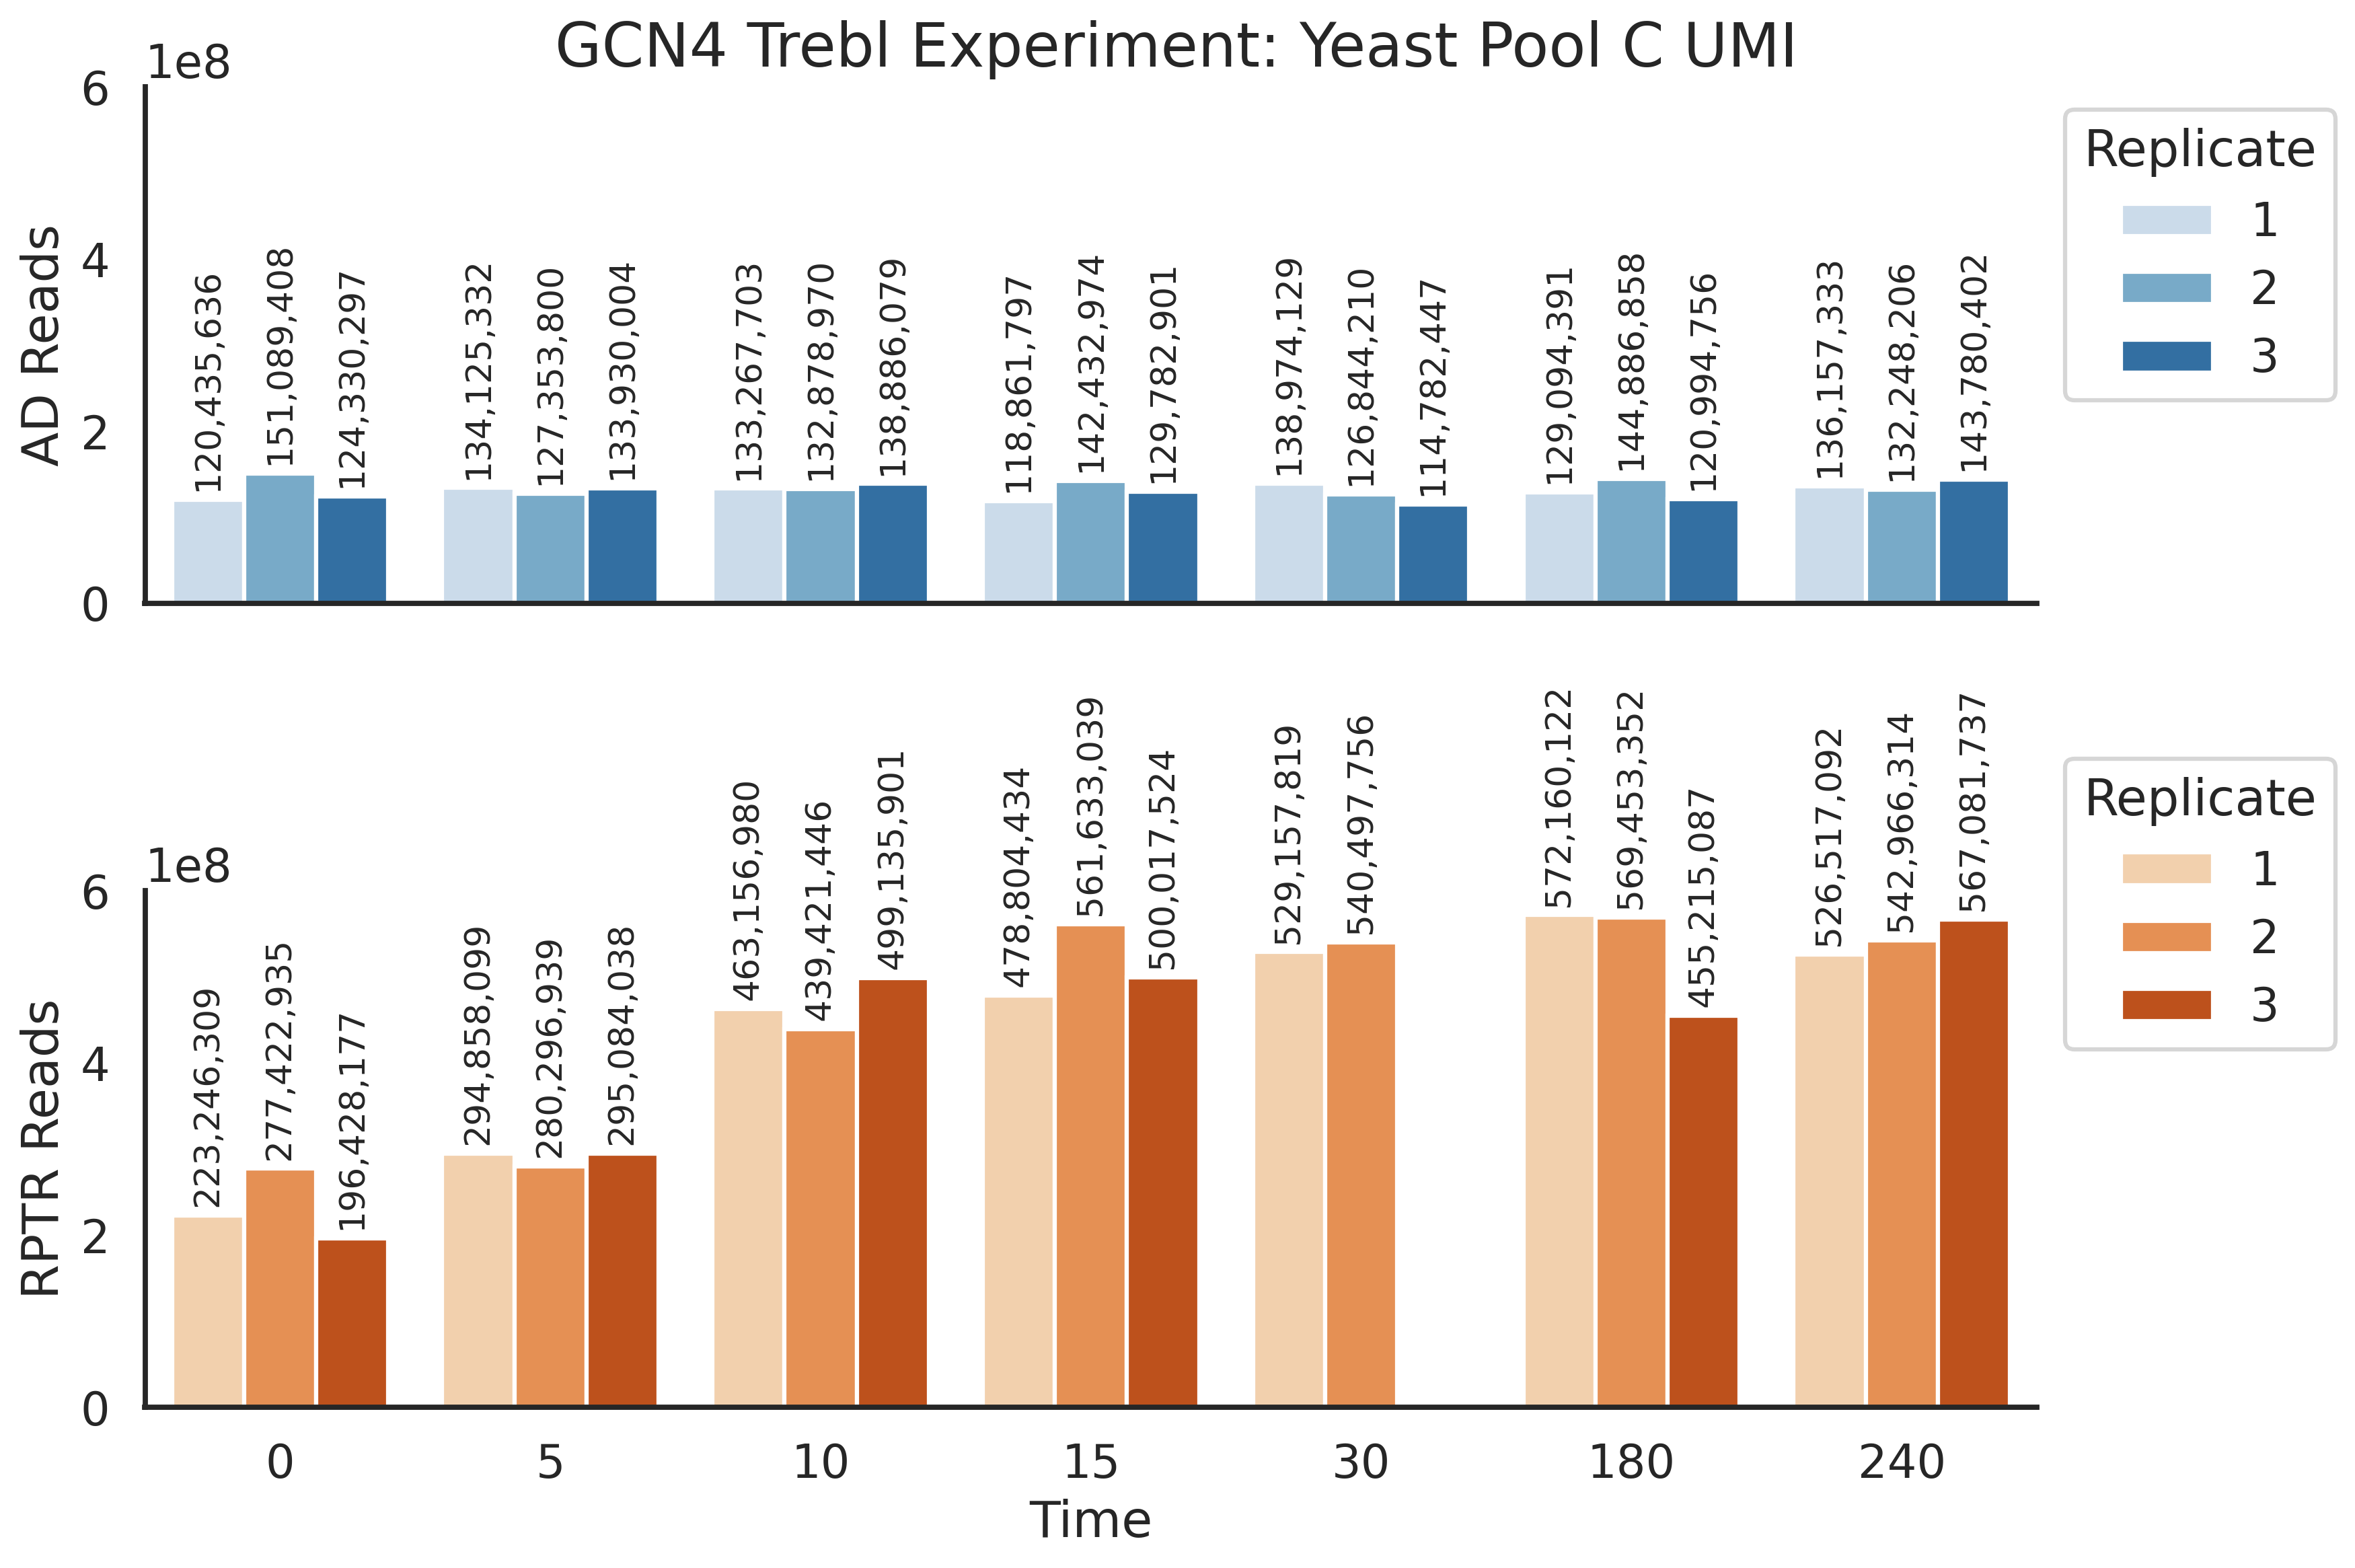

In [79]:
# Set style
sns.set(style="white")

df = reads_per_sample_pivot.reset_index()

df['time'] = pd.to_numeric(df['time'], errors='coerce')
df['rep'] = df['rep'].astype(str)  # convert to string for hue

sns.set_context('talk')

# Create figure with 2 subplots (AD and RPTR)
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey = True, dpi = 300)

# Plot AD reads
ax = axes[0]

sns.barplot(data=df, x='time', y='AD', hue='rep', palette='Blues', ci=None, ax=axes[0])
axes[0].set_ylabel('AD Reads')
axes[0].legend(title='Replicate', loc = 'upper right', bbox_to_anchor = (1.17,1))
axes[0].set_xlabel("")

# Annotate counts above bars
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.annotate(f'{int(height):,}', 
                    (p.get_x() + p.get_width() / 2., height + 10000000),
                    ha='center', va='bottom', rotation=90, fontsize='x-small')
        
# Plot RPTR reads
ax = axes[1]

sns.barplot(data=df, x='time', y='RPTR', hue='rep', palette='Oranges', ci=None, ax=axes[1])
axes[1].set_ylabel('RPTR Reads')
axes[1].set_xlabel('Time')
axes[1].legend(title='Replicate', loc = 'upper right', bbox_to_anchor = (1.17,1.3))

# Annotate counts above bars
for p in ax.patches:
    height = p.get_height()
    if not pd.isna(height):
        ax.annotate(f'{int(height):,}', 
                    (p.get_x() + p.get_width() / 2., height + 10000000),
                    ha='center', va='bottom', rotation=90, fontsize='x-small')
        
sns.despine()
plt.tight_layout()

plt.suptitle("GCN4 Trebl Experiment: Yeast Pool C UMI")
plt.show()

# How many colonies?

In [80]:
step1_map_name = "step1_AD_AD_BC_RPTR_BC_designed"

In [116]:
table_names_pivot.dropna()

seq,time,rep,AD,RPTR
0,0,1,trebl_experiment_yeast_pool_C_umi_AD_1_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_1_0_S1_...
1,0,2,trebl_experiment_yeast_pool_C_umi_AD_2_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_2_0_S8_...
2,0,3,trebl_experiment_yeast_pool_C_umi_AD_3_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_3_0_S15...
3,5,1,trebl_experiment_yeast_pool_C_umi_AD_1_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_1_5_S2_...
4,5,2,trebl_experiment_yeast_pool_C_umi_AD_2_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_2_5_S9_...
5,5,3,trebl_experiment_yeast_pool_C_umi_AD_3_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_3_5_S16...
6,10,1,trebl_experiment_yeast_pool_C_umi_AD_1_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_1_10_S3...
7,10,2,trebl_experiment_yeast_pool_C_umi_AD_2_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_2_10_S1...
8,10,3,trebl_experiment_yeast_pool_C_umi_AD_3_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_3_10_S1...
9,15,1,trebl_experiment_yeast_pool_C_umi_AD_1_15_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_1_15_S4...


In [117]:
table_names_pivot = table_names_pivot.dropna()
table_names_pivot = table_names_pivot.reset_index(drop = True)
table_names_pivot

seq,time,rep,AD,RPTR
0,0,1,trebl_experiment_yeast_pool_C_umi_AD_1_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_1_0_S1_...
1,0,2,trebl_experiment_yeast_pool_C_umi_AD_2_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_2_0_S8_...
2,0,3,trebl_experiment_yeast_pool_C_umi_AD_3_0_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_3_0_S15...
3,5,1,trebl_experiment_yeast_pool_C_umi_AD_1_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_1_5_S2_...
4,5,2,trebl_experiment_yeast_pool_C_umi_AD_2_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_2_5_S9_...
5,5,3,trebl_experiment_yeast_pool_C_umi_AD_3_5_AD_AD...,trebl_experiment_yeast_pool_C_umi_RPTR_3_5_S16...
6,10,1,trebl_experiment_yeast_pool_C_umi_AD_1_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_1_10_S3...
7,10,2,trebl_experiment_yeast_pool_C_umi_AD_2_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_2_10_S1...
8,10,3,trebl_experiment_yeast_pool_C_umi_AD_3_10_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_3_10_S1...
9,15,1,trebl_experiment_yeast_pool_C_umi_AD_1_15_AD_A...,trebl_experiment_yeast_pool_C_umi_RPTR_1_15_S4...


In [114]:
# results = []


In [121]:
# Assuming table_names_pivot is your DataFrame

for idx, row in table_names_pivot.iloc[14:].iterrows():
    ad_table = row["AD"]
    rptr_table = row["RPTR"]

    print(f"\n=== Processing row {idx} ===")
    print(f"AD table: {ad_table}")
    print(f"RPTR table: {rptr_table}")

    if pd.isna(rptr_table):
        print("RPTR table is NaN, skipping this row.")
        results.append({
            "seq": row["seq"],
            "time": row["time"],
            "rep": row["rep"],
            "AD_table": ad_table,
            "RPTR_table": rptr_table,
            "matched_rows": None
        })
        continue

    # Step 1: truncate RPTR_BC to first 14 bases
    print(f"Truncating RPTR_BC in {rptr_table} to first 14 bases...")
    con.execute(f"""
        UPDATE {rptr_table}
        SET RPTR_BC = substr(RPTR_BC, 1, 14);
    """)
    print("Truncation complete.")

    # Step 2: count matching rows
    print("Counting matching rows...")
    query = f"""
    SELECT COUNT(*) AS matched_rows
    FROM step1_AD_AD_BC_RPTR_BC_designed s
    WHERE 
        (LOWER(TRIM(s.AD)), LOWER(TRIM(s.AD_BC))) IN (
            SELECT LOWER(TRIM(AD)), LOWER(TRIM(AD_BC))
            FROM {ad_table}
        )
        AND LOWER(TRIM(s.RPTR_BC)) IN (
            SELECT LOWER(TRIM(RPTR_BC))
            FROM {rptr_table}
        );
    """

    count = con.execute(query).fetchone()[0]
    print(f"Number of matching rows for this row: {count}")

    # Append results
    results.append({
        "time": row["time"],
        "rep": row["rep"],
        "integrations": count
    })



=== Processing row 14 ===
AD table: trebl_experiment_yeast_pool_C_umi_AD_1_180_AD_AD_BC_initial
RPTR table: trebl_experiment_yeast_pool_C_umi_RPTR_1_180_S6_R1_001_fastp_RPTR_BC_initial
Truncating RPTR_BC in trebl_experiment_yeast_pool_C_umi_RPTR_1_180_S6_R1_001_fastp_RPTR_BC_initial to first 14 bases...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Truncation complete.
Counting matching rows...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Number of matching rows for this row: 14655

=== Processing row 15 ===
AD table: trebl_experiment_yeast_pool_C_umi_AD_2_180_AD_AD_BC_initial
RPTR table: trebl_experiment_yeast_pool_C_umi_RPTR_2_180_S13_R1_001_fastp_RPTR_BC_initial
Truncating RPTR_BC in trebl_experiment_yeast_pool_C_umi_RPTR_2_180_S13_R1_001_fastp_RPTR_BC_initial to first 14 bases...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Truncation complete.
Counting matching rows...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Number of matching rows for this row: 14627

=== Processing row 16 ===
AD table: trebl_experiment_yeast_pool_C_umi_AD_3_180_AD_AD_BC_initial
RPTR table: trebl_experiment_yeast_pool_C_umi_RPTR_3_180_S20_R1_001_fastp_RPTR_BC_initial
Truncating RPTR_BC in trebl_experiment_yeast_pool_C_umi_RPTR_3_180_S20_R1_001_fastp_RPTR_BC_initial to first 14 bases...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Truncation complete.
Counting matching rows...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Number of matching rows for this row: 14634

=== Processing row 17 ===
AD table: trebl_experiment_yeast_pool_C_umi_AD_1_240_AD_AD_BC_initial
RPTR table: trebl_experiment_yeast_pool_C_umi_RPTR_1_240_S7_R1_001_fastp_RPTR_BC_initial
Truncating RPTR_BC in trebl_experiment_yeast_pool_C_umi_RPTR_1_240_S7_R1_001_fastp_RPTR_BC_initial to first 14 bases...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Truncation complete.
Counting matching rows...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Number of matching rows for this row: 14719

=== Processing row 18 ===
AD table: trebl_experiment_yeast_pool_C_umi_AD_2_240_AD_AD_BC_initial
RPTR table: trebl_experiment_yeast_pool_C_umi_RPTR_2_240_S14_R1_001_fastp_RPTR_BC_initial
Truncating RPTR_BC in trebl_experiment_yeast_pool_C_umi_RPTR_2_240_S14_R1_001_fastp_RPTR_BC_initial to first 14 bases...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Truncation complete.
Counting matching rows...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Number of matching rows for this row: 14658

=== Processing row 19 ===
AD table: trebl_experiment_yeast_pool_C_umi_AD_3_240_AD_AD_BC_initial
RPTR table: trebl_experiment_yeast_pool_C_umi_RPTR_3_240_S21_R1_001_fastp_RPTR_BC_initial
Truncating RPTR_BC in trebl_experiment_yeast_pool_C_umi_RPTR_3_240_S21_R1_001_fastp_RPTR_BC_initial to first 14 bases...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Truncation complete.
Counting matching rows...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Number of matching rows for this row: 14684


In [126]:
# Convert results list to DataFrame
df_counts = pd.DataFrame(results)
df_counts["rep"] = df_counts["rep"].astype(str)
df_counts

,time,rep,integrations
0,0,1,13923
1,0,2,13996
2,0,3,14117
3,5,1,14136
4,5,2,14142
5,5,3,14184
6,10,1,14339
7,10,2,14344
8,10,3,14299
9,15,1,14243


<Figure size 1920x1440 with 0 Axes>

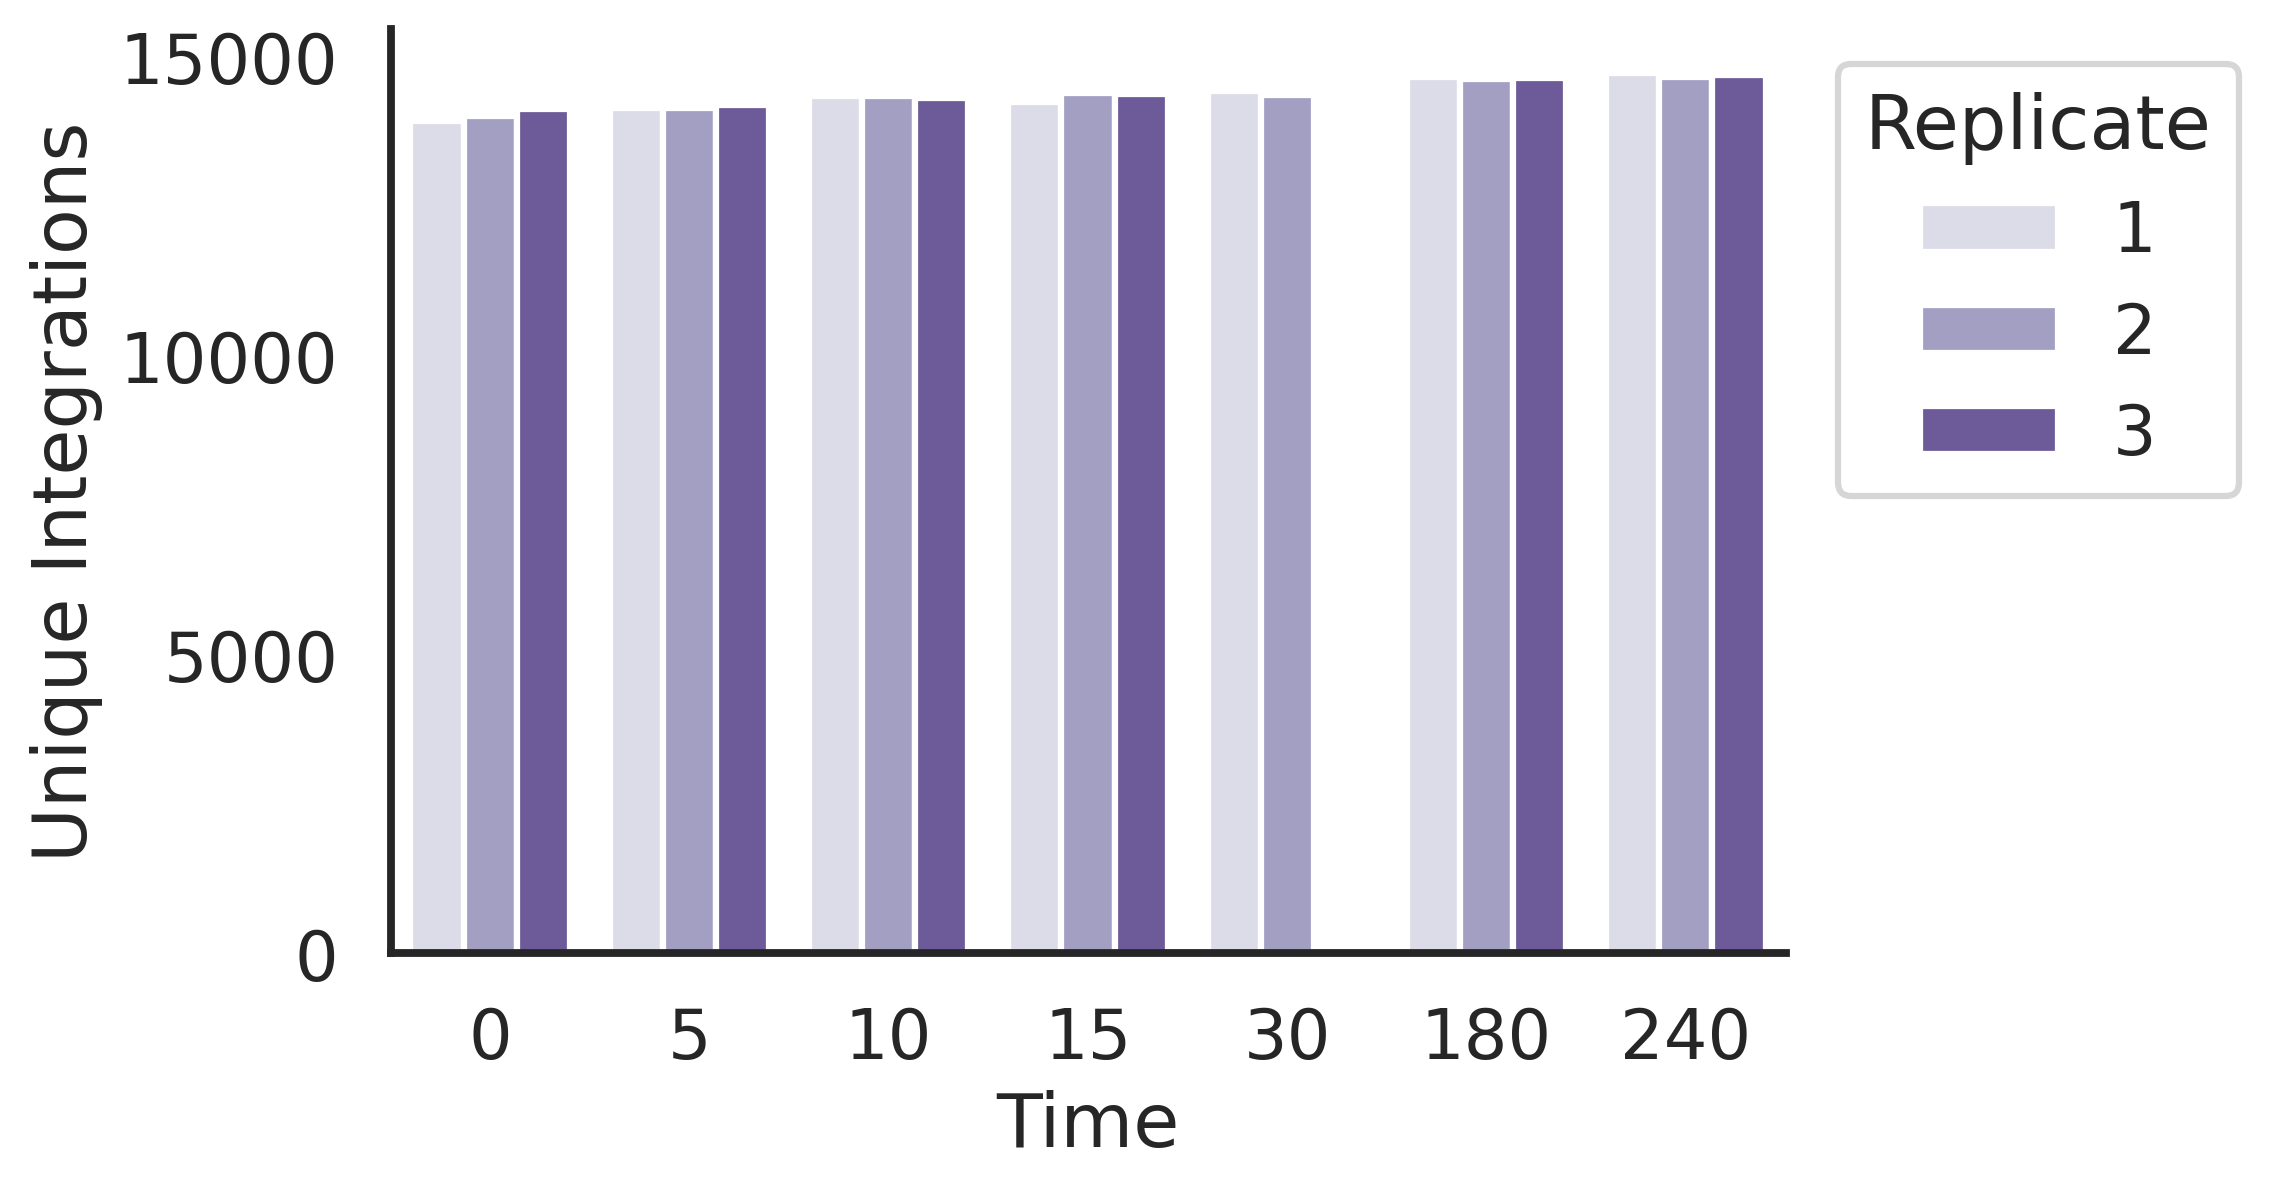

In [138]:
plt.figure(dpi = 300)
plt.figure(figsize=(6,4), dpi = 300)
sns.barplot(data=df_counts, x='time', y='integrations', hue='rep', palette='Purples', ci=None)
plt.legend(bbox_to_anchor = (1.35,1), loc = 'upper right', title = "Replicate")
plt.xlabel("Time")
plt.ylabel("Unique Integrations")
sns.despine()

In [139]:
df_counts.to_csv("../../output/unique_integrations_gcn4.csv")